In [335]:
import io
import numpy as np
from scipy import optimize
import pandas as pd
import matplotlib.pyplot as plt
import math
#%matplotlib qt
%matplotlib inline

In [336]:
CH_data = pd.read_fwf("C:/Users/willi/Desktop/Savin Group/rate_CH.txt", widths = [13, 13, 13, 13])

CH2_data = pd.read_fwf("C:/Users/willi/Desktop/Savin Group/rate_CH2.txt", widths = [13, 13, 13, 13])
# 'voltage' 'energy' 'rate' 'uncertainty

In [337]:
def original(T, a_0, a_12, a_1, b_12, b_1, b_32):
    upper  = a_0 + (a_12)*(T**(1/2)) + a_1*T
    lower = T**(1/6) + (b_12)*(T**(1/2)) + (b_1)*(T) + (b_32)*(T**(3/2))
    value = upper/lower
    return value

In [338]:
temps = np.logspace(0, 4, 30000)

Statistical populations for each J-Level, and derived thermal rate coefficient


In [339]:
#from nist, 0->0, 1->16.41671  2->0.00538258776
#conversion factor = 0.000123984193

In [340]:
def population(T, J):
    energylist = [0, 0.00203541254, 5.4e-3]
    G = (2*J)+1
    Kb = 8.314e-5
    upper = G*np.exp(-1*energylist[J]/(Kb*T))
    lower = 0
    for Ji in range(3):
        value = ((2*Ji)+1)*np.exp(-1*energylist[Ji]/(Kb*T))
        lower += value
    return (upper/lower)

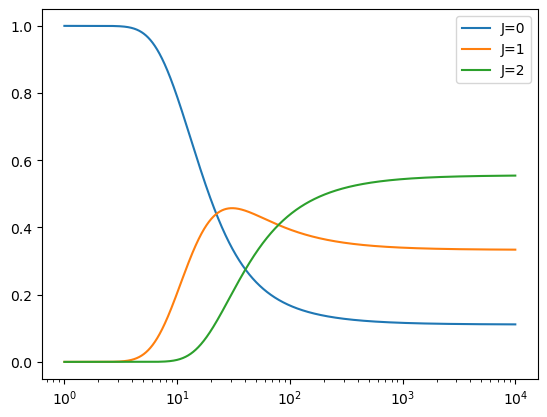

In [341]:
pop_0 = [population(temp, 0) for temp in temps]
plt.plot(temps, pop_0, label = "J=0")
pop_1 = [population(temp, 1) for temp in temps]
plt.plot(temps, pop_1, label = "J=1")
pop_2 = [population(temp, 2) for temp in temps]
plt.plot(temps, pop_2, label = "J=2")
plt.xscale("log")
plt.legend()

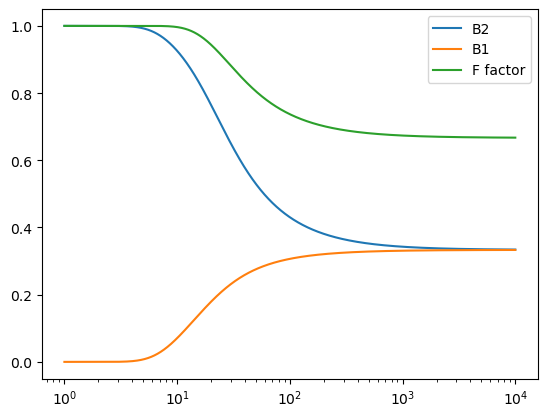

In [342]:
B2 = [pop_0[char] + (2/3)*pop_1[char] for char in range(len(temps))]
B1 = [(1/3)*pop_1[char] + (2/5)*pop_2[char] for char in range(len(temps))]
F = [B2[char] + B1[char] for char in range(len(temps))]
plt.plot(temps, B2, label = "B2")
plt.plot(temps, B1, label = "B1")
plt.xscale("log")
plt.plot(temps, F, label = "F factor")
plt.legend()

 C + H3+  ->  CH+ + H2
 Measured from 72 k to 10^4 K

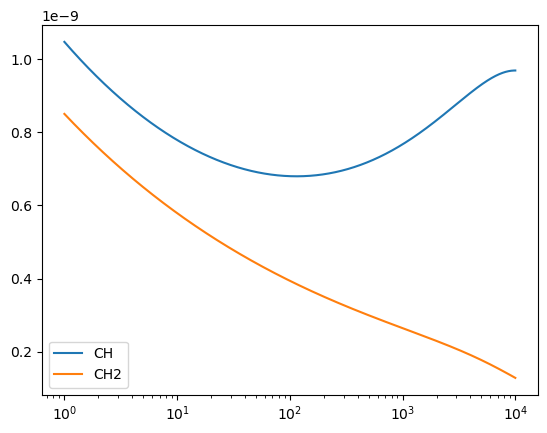

In [343]:
ratesCH = [original(temp, 1.0218E-09, 7.2733E-11, 5.9203E-14, 4.4914E-02, -2.6056E-04, 2.6397E-06) for temp in temps]    
ratesCH2 = [original(temp, 8.5145E-10, 0, 0, 9.5666E-04, -4.4040E-05, 2.3496E-06) for temp in temps]
    
plt.plot(temps, ratesCH, label = "CH")
plt.plot(temps, ratesCH2, label = "CH2")
plt.xscale("log")
plt.legend()

In [344]:
"""
Reaction 3 = CH
Reaction 5 = CH2
1. Sum coefficnts, and multiply by 3f/2 (gives both)
2. Multiply CH2 by 3*B2 -> gives CH2
3. Subtract to obtain CH
"""


'\nReaction 3 = CH\nReaction 5 = CH2\n1. Sum coefficnts, and multiply by 3f/2 (gives both)\n2. Multiply CH2 by 3*B2 -> gives CH2\n3. Subtract to obtain CH\n'

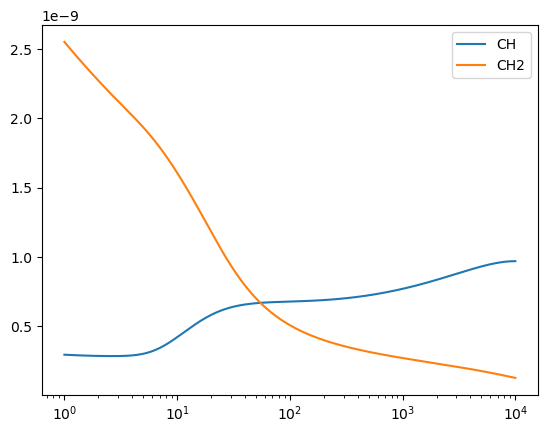

In [345]:
summed = [(ratesCH[char] + ratesCH2[char])*(3/2)*F[char]for char in range(len(temps))]
CH2_thermal = [ratesCH2[char]*3*B2[char]for char in range(len(temps))]
CH_thermal = [summed[char] - CH2_thermal[char] for char in range(len(temps))]
plt.plot(temps, CH_thermal, label = "CH")
plt.plot(temps, CH2_thermal, label = "CH2")
plt.xscale("log")
plt.legend()

Kinetic Tempature vs Thermal Rate coefficent

In [346]:
KT_summed = [ratesCH[char] + ratesCH2[char] for char in range(len(temps))]
TR_summed = [CH_thermal[char] + CH2_thermal[char] for char in range(len(temps))]
p_error = [100*(KT_summed[char]-TR_summed[char])/TR_summed[char] for char in range(len(temps))]

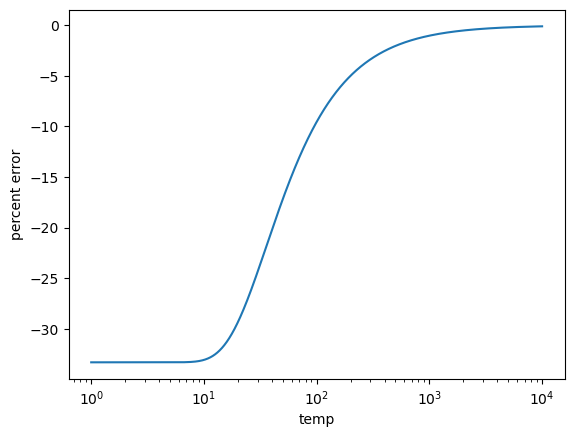

In [347]:
plt.plot(temps, p_error)
plt.xlabel("temp")
plt.ylabel("percent error")
plt.xscale("log")

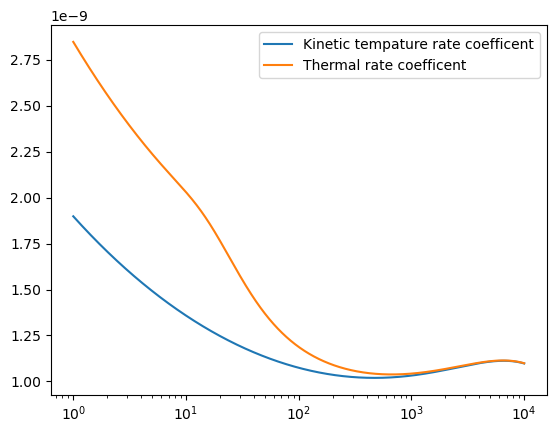

In [348]:
plt.plot(temps, KT_summed, label = "Kinetic tempature rate coefficent")
plt.plot(temps, TR_summed, label = "Thermal rate coefficent " )
plt.xscale("log")
plt.legend()

In [349]:
#vissennprada fits
def vfit(T, A, n, c1, c2, c3, c4, T1, T2, T3, T4):
    sum1 = c1 * np.exp(-T1/T)
    sum2 = c2 * np.exp(-T2/T)
    sum3 = c3 * np.exp(-T3/T)
    sum4 = c4 * np.exp(-T4/T)
    value = A * ((300/T)**n) + (T**(-3/2))*(sum1+ sum2+sum3+sum4)
    return value

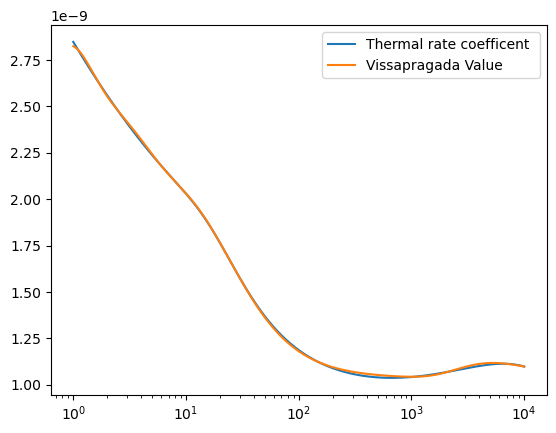

In [350]:
v_data = [vfit(temp, 1.04e-9, 2.31e-3, 3.40e-8, 6.97e-9, 1.31e-7, 1.51e-4, 7.62, 1.38, 2.66e1, 8.11e3) for temp in temps]
plt.plot(temps, TR_summed, label = "Thermal rate coefficent " )
plt.plot(temps, v_data, label = "Vissapragada Value" )
plt.xscale("log")
plt.legend()

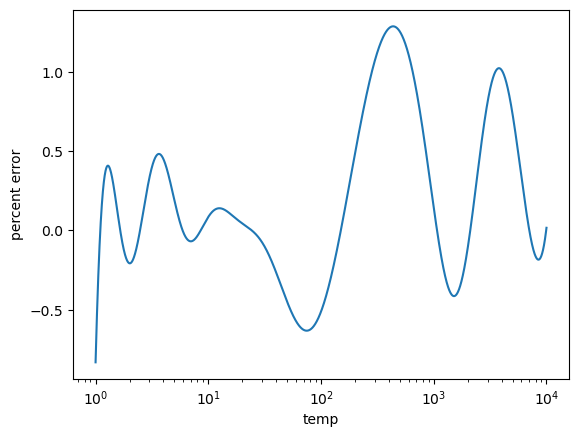

In [351]:
pv_error = [100*(v_data[char]-TR_summed[char])/TR_summed[char] for char in range(len(temps))]
plt.plot(temps, pv_error)
plt.xlabel("temp")
plt.ylabel("percent error")
plt.xscale("log")

Some functions

In [293]:
def AK_1_fit(T, a, b, gamma):
    value = a * ((T/300)**b) * np.exp(-gamma/T)
    return value

def AK_2_fit(T, T1, a1, b1, gamma1, b2, gamma2):
    a2 = (a1 * ((T1/300)**(b1-b2))*np.exp((gamma2-gamma1)/T1))
    return np.piecewise(T, [(T <= T1), (T> T1)], 
                        [lambda T:(a1 * ((T/300)**b1) * np.exp(-gamma1/T)), 
                         lambda T:(a2 * ((T/300)**b2) * np.exp(-gamma2/T))])

def AK_3_fit(T, T1, T2, a1, b1, gamma1, b2, gamma2, b3, gamma3):
    a2 = (a1 * ((T1/300)**(b1-b2))*np.exp((gamma2-gamma1)/T1))
    a3 = (a2 * ((T2/300)**(b2-b3))*np.exp((gamma3-gamma2)/T2))
    return np.piecewise(T, [(T <= T1), (T> T1) & (T<=T2), (T>T2)], 
                        [lambda T:(a1 * ((T/300)**b1) * np.exp(-gamma1/T)), 
                         lambda T:(a2*((T/300)**b2) * np.exp(-gamma2/T)),
                         lambda T:(a3*((T/300)**b3) * np.exp(-gamma3/T))])

def AK_4_fit(T, T1, T2, T3, a1, b1, gamma1, b2, gamma2, b3, gamma3, b4, gamma4):
    a2 = (a1 * ((T1/300)**(b1-b2))*np.exp((gamma2-gamma1)/T1))
    a3 = (a2 * ((T2/300)**(b2-b3))*np.exp((gamma3-gamma2)/T2))
    a4 = (a3 * ((T3/300)**(b3-b4))*np.exp((gamma4-gamma3)/T3))
    return np.piecewise(T, [(T <= T1), (T> T1) & (T<=T2), (T>T2) & (T<=T3), T>T3], 
                        [lambda T:(a1 * ((T/300)**b1) * np.exp(-gamma1/T)), 
                         lambda T:(a2*((T/300)**b2) * np.exp(-gamma2/T)),
                         lambda T:(a3*((T/300)**b3) * np.exp(-gamma3/T)),
                         lambda T:(a4*((T/300)**b4) * np.exp(-gamma4/T))
                        ])
def uncertain_list(real, measured, uncertainty):
    delta = []
    for char in range(len(real)):
        num_up = math.exp(((real[char]*(1+uncertainty))-measured[char])/measured[char])
        num_down = math.exp(((real[char]*(1-uncertainty))-measured[char])/measured[char])
        num = (abs(1-num_up) + abs(1-num_down))/2 + 1
        delta.append(num)
    return delta
        
def uncertain_parametersCH(T, f1, g1, g2, g3, g4):
    T1 = 4.94382573e+00
    T2 = 1.57148197e+01
    T3 = 7.52379661e+01
    f2 = f1*np.exp(g1*((1/T1)-(1/300)))/np.exp(g2*((1/T1)-(1/300)))
    f3 = f2*np.exp(g2*((1/T2)-(1/300)))/np.exp(g3*((1/T2)-(1/300)))
    f4 = f3*np.exp(g3*((1/T3)-(1/300)))/np.exp(g4*((1/T3)-(1/300)))
    return np.piecewise(T, [(T <= T1), (T> T1) & (T<=T2), (T>T2) & (T<=T3), T>T3], 
                        [lambda T:f1 * np.exp(g1*((1/T) - (1/300))), 
                         lambda T:f2 * np.exp(g2*((1/T) - (1/300))),
                         lambda T:f3 * np.exp(g3*((1/T) - (1/300))),
                         lambda T:f4 * np.exp(g4*((1/T) - (1/300)))
                        ])

def uncertain_parametersCH2(T, f1, g1, g2, g3, g4):
    T1 = 283
    T2 = 1330
    T3 = 3760
    f2 = f1*np.exp(g1*((1/T1)-(1/300)))/np.exp(g2*((1/T1)-(1/300)))
    f3 = f2*np.exp(g2*((1/T2)-(1/300)))/np.exp(g3*((1/T2)-(1/300)))
    f4 = f3*np.exp(g3*((1/T3)-(1/300)))/np.exp(g4*((1/T3)-(1/300)))
    return np.piecewise(T, [(T <= T1), (T> T1) & (T<=T2), (T>T2) & (T<=T3), T>T3], 
                        [lambda T:f1 * np.exp(g1*((1/T) - (1/300))), 
                         lambda T:f2 * np.exp(g2*((1/T) - (1/300))),
                         lambda T:f3 * np.exp(g3*((1/T) - (1/300))),
                         lambda T:f4 * np.exp(g4*((1/T) - (1/300)))
                        ])

def fnumsCH(f1, g1, g2, g3, g4):
    T1 = 17.4
    T2 = 169
    T3 = 4440
    f2 = f1*np.exp(g1*((1/T1)-(1/300)))/np.exp(g2*((1/T1)-(1/300)))
    f3 = f2*np.exp(g2*((1/T2)-(1/300)))/np.exp(g3*((1/T2)-(1/300)))
    f4 = f3*np.exp(g3*((1/T3)-(1/300)))/np.exp(g4*((1/T3)-(1/300)))
    return (f2, f3, f4)

def fnumsCH2(f1, g1, g2, g3, g4):
    T1 = 283
    T2 = 1330
    T3 = 3760
    f2 = f1*np.exp(g1*((1/T1)-(1/300)))/np.exp(g2*((1/T1)-(1/300)))
    f3 = f2*np.exp(g2*((1/T2)-(1/300)))/np.exp(g3*((1/T2)-(1/300)))
    f4 = f3*np.exp(g3*((1/T3)-(1/300)))/np.exp(g4*((1/T3)-(1/300)))
    return (f2, f3, f4)

CH fits

In [227]:
poptCH, pcovCH = optimize.curve_fit(AK_1_fit, temps, CH_thermal, method="lm")
print(poptCH)

[7.16677917e-10 8.90444426e-02 1.01723812e+00]


C:\Users\willi\AppData\Local\Temp\ipykernel_34644\4095686196.py:2: RuntimeWarning: overflow encountered in exp
  value = a * ((T/300)**b) * np.exp(-gamma/T)


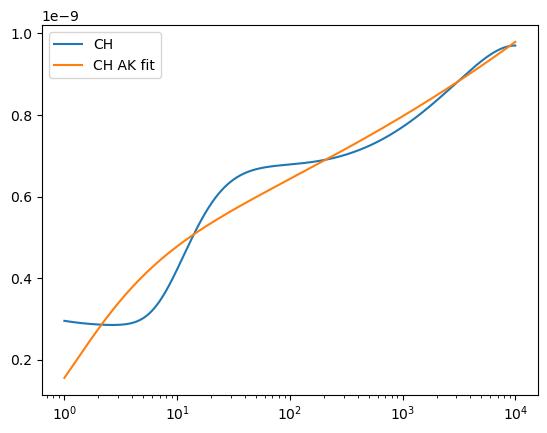

In [228]:
CH_1_AK = [AK_1_fit(temp, 7.16677917e-10, 8.90444426e-02, 1.01723812e+00) for temp in temps]
CH_1_AK_error = [100*(CH_1_AK[char] - CH_thermal[char])/CH_thermal[char] for char in range(len(temps))]
plt.plot(temps, CH_thermal, label = "CH")
plt.plot(temps, CH_1_AK, label = "CH AK fit")
plt.xscale("log")
plt.legend()

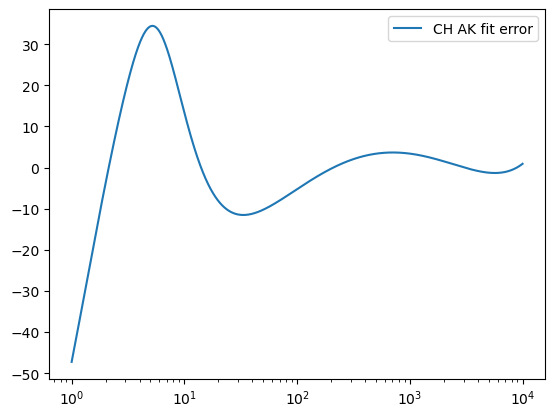

In [229]:
plt.plot(temps, CH_1_AK_error, label = "CH AK fit error")
plt.xscale("log")
plt.legend()

In [259]:
guess = (1.5e2, 1,1,1,1,1)
poptCH, pcovCH = optimize.curve_fit(AK_2_fit, temps, CH_thermal,p0 = guess, method="lm")
print(poptCH)

C:\Users\willi\AppData\Local\Temp\ipykernel_34644\4095686196.py:6: RuntimeWarning: invalid value encountered in double_scalars
  a2 = (a1 * ((T1/300)**(b1-b2))*np.exp((gamma2-gamma1)/T1))


[ 2.88630319e+01  2.22954571e-09  5.23204996e-01 -1.04173069e+00
  9.97339756e-02 -6.16020698e+00]


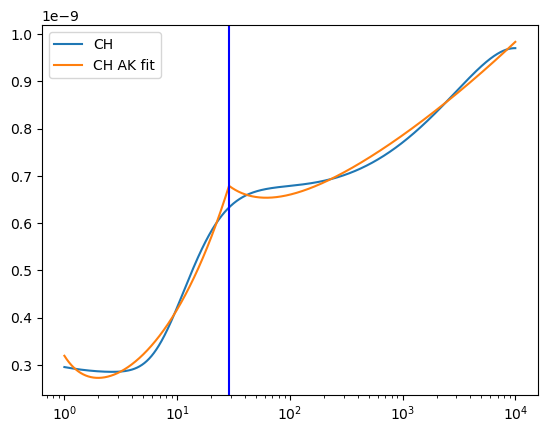

In [260]:
CH_2_AK = [AK_2_fit(temp, 2.88630319e+01, 2.22954571e-09,  5.23204996e-01, -1.04173069e+00,
  9.97339756e-02, -6.16020697e+00) for temp in temps]
CH_2_AK_error = [100*(CH_2_AK[char] - CH_thermal[char])/CH_thermal[char] for char in range(len(temps))]
plt.plot(temps, CH_thermal, label = "CH")
plt.plot(temps, CH_2_AK, label = "CH AK fit")
plt.axvline(x =  2.88630319e+01, color = 'b')
plt.xscale("log")
plt.legend()

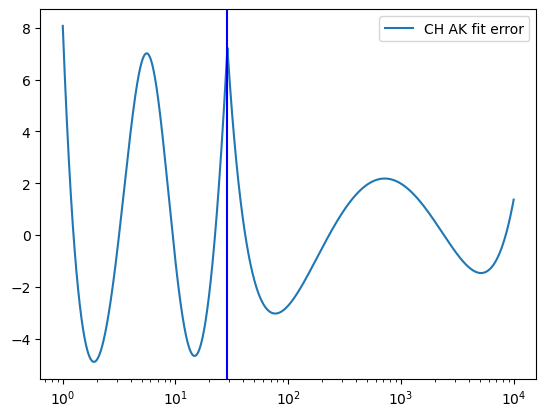

In [261]:
plt.plot(temps, CH_2_AK_error, label = "CH AK fit error")
plt.axvline(x =  2.88630319e+01, color = 'b')
plt.xscale("log")
plt.legend()

In [268]:
guess = (1e2,1e3,1,1,1,1,1,1,1)
poptCH, pcovCH = optimize.curve_fit(AK_3_fit, temps, CH_thermal,p0 = guess, method="lm", maxfev=10000, ftol = 1e-10)
print(poptCH)

C:\Users\willi\AppData\Local\Temp\ipykernel_34644\4095686196.py:12: RuntimeWarning: invalid value encountered in double_scalars
  a2 = (a1 * ((T1/300)**(b1-b2))*np.exp((gamma2-gamma1)/T1))


[ 1.90926278e+01  1.26962769e+02  2.72370607e-09  5.84542236e-01
 -1.22375319e+00 -5.57008600e-02  5.95892870e+00  1.15908215e-01
 -1.58289691e+01]


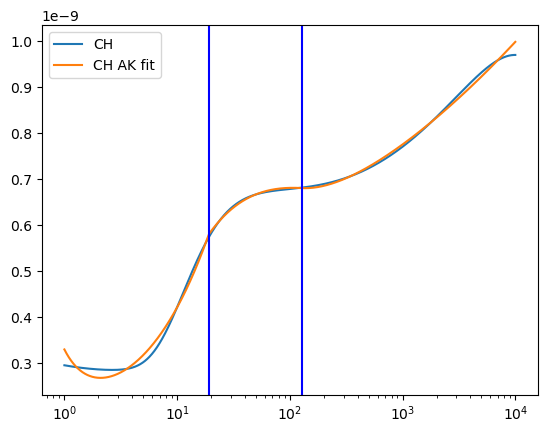

In [271]:
CH_3_AK = [AK_3_fit(temp, 1.90926278e+01,  1.26962769e+02,  2.72370607e-09,  5.84542236e-01,
 -1.22375319e+00, -5.57008600e-02,  5.95892870e+00,  1.15908215e-01,
 -1.58289691e+01) for temp in temps]
CH_3_AK_error = [100*(CH_3_AK[char] - CH_thermal[char])/CH_thermal[char] for char in range(len(temps))]
plt.plot(temps, CH_thermal, label = "CH")
plt.plot(temps, CH_3_AK, label = "CH AK fit")
plt.axvline(x =  1.90926278e+01, color = 'b')
plt.axvline(x =  1.26962769e+02, color = 'b')
plt.xscale("log")
plt.legend()

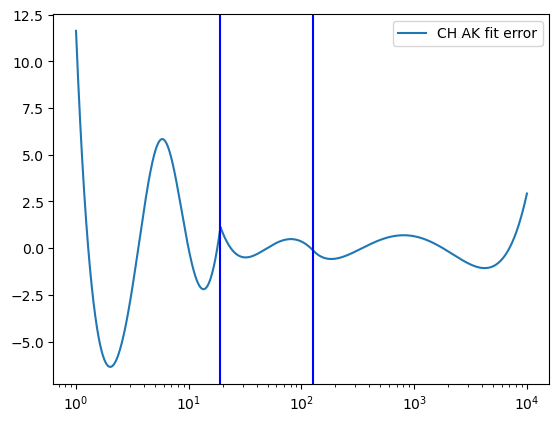

In [286]:
plt.plot(temps, CH_3_AK_error, label = "CH AK fit error")
plt.axvline(x =  1.90926278e+01, color = 'b')
plt.axvline(x =  1.26962769e+02, color = 'b')
plt.xscale("log")
plt.legend()

In [283]:
guess = (5e0, 1.90926278e+01,  1.26962769e+02,  1e-5, 1e-5, 2.72370607e-09,  5.84542236e-01,
 -1.22375319e+00, -5.57008600e-02,  5.95892870e+00,  1.15908215e-01,
 -1.58289691e+01)
poptCH, pcovCH = optimize.curve_fit(AK_4_fit, temps, CH_thermal,p0 = guess, method="lm", maxfev=10000, ftol = 1e-10)
print(poptCH)

[ 4.94382573e+00  1.57148197e+01  7.52379661e+01  3.04333316e-10
  1.23783452e-02 -3.80645503e-02  4.98746803e-01  2.65028627e-01
 -1.56138976e-01  9.21459581e+00  1.08873712e-01 -1.07218009e+01]


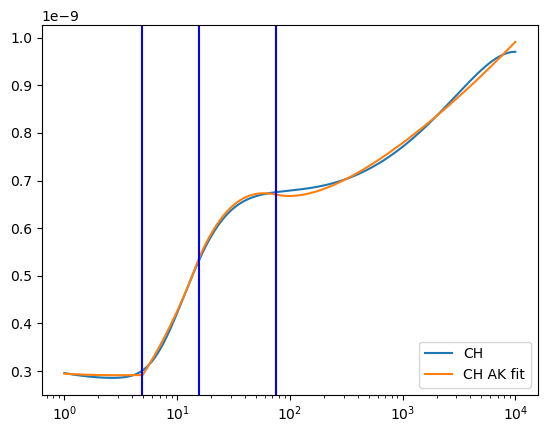

In [290]:
CH_4_AK = [AK_4_fit(temp,  4.94382573e+00,  1.57148197e+01,  7.52379661e+01,  3.04333316e-10,
  1.23783452e-02, -3.80645503e-02,  4.98746803e-01,  2.65028627e-01,
 -1.56138976e-01,  9.21459581e+00,  1.08873712e-01, -1.07218009e+01) for temp in temps]
CH_4_AK_error = [100*(CH_4_AK[char] - CH_thermal[char])/CH_thermal[char] for char in range(len(temps))]
plt.plot(temps, CH_thermal, label = "CH")
plt.plot(temps, CH_4_AK, label = "CH AK fit")
plt.axvline(x =  4.91750737e+00, color = 'b')
plt.axvline(x =  1.57148197e+01, color = 'b')
plt.axvline(x =  7.52379661e+01, color = 'b')
plt.xscale("log")
plt.legend()

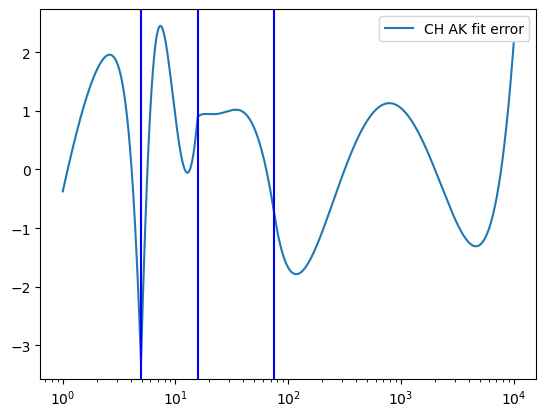

In [292]:
plt.plot(temps, CH_4_AK_error, label = "CH AK fit error")
plt.axvline(x =  4.91750737e+00, color = 'b')
plt.axvline(x =  1.57148197e+01, color = 'b')
plt.axvline(x =  7.52379661e+01, color = 'b')
plt.xscale("log")
plt.legend()

In [297]:
f_listCH = uncertain_list(CH_thermal, CH_4_AK, .13)
poptCH_un, pcovCH_un = optimize.curve_fit(uncertain_parametersCH, temps, f_listCH, method="lm", maxfev=10000, ftol = 1e-10)
print(poptCH_un)

[ 1.12896613e+00 -1.04503827e-03  1.15557724e-02 -8.38139462e-02
  7.93259994e-02]


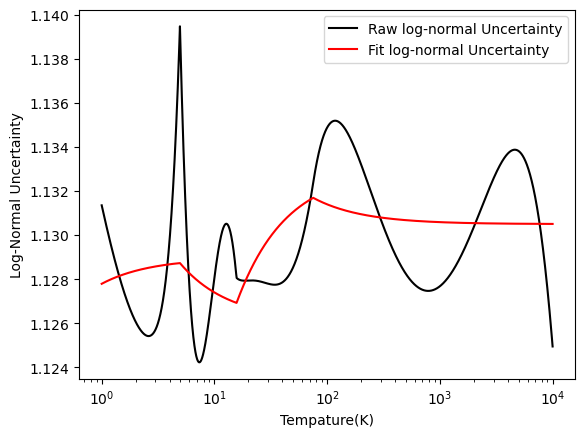

In [299]:
CH_ln = [uncertain_parametersCH(temp, 1.12896613e+00, -1.04503827e-03,  1.15557724e-02, -8.38139462e-02,
  7.93259994e-02) for temp in temps]
plt.plot(temps, f_listCH, c = "black", label = "Raw log-normal Uncertainty")
plt.plot(temps, CH_ln, c = "red", label = "Fit log-normal Uncertainty")
plt.xscale("log")
plt.xlabel("Tempature(K)")
plt.ylabel("Log-Normal Uncertainty")
plt.legend()